# Investigate protoypicality of examples on the latent space

##### 1. Setup VAE architecture and training functions
##### 2. Train ordinary VAE and investigate its decision boundary
##### 3. Investigate points at the centre and the periphery in each digit's latent space of the VAE 

## 1. Setup VAE architecture and training functions

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [7]:
## Common VAE architecture
#MODEL
#Input image --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output image
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()

        #take image: convert to hidden dim
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        #encoder: encode to mean and std
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        #decoder: decode to image
        #first: flatten: z to hidden dim
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        #second, hidden dim to image
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        #define relu
        self.relu = nn.ReLU()

        
    def encode(self, x):
        #q_phi(z|x)
        
        #flatten
        h = self.relu(self.img_2hid(x))
        
        #get mean, var
        mu = self.hid_2mu(h)
        
        #get variance (and ensure it's positive with softplus)
        #sigma = self.hid_2sigma(h)
        sigma = F.softplus(self.hid_2sigma(h))
    
        return mu, sigma


    def decode(self, z):
        #p_theta(x|z)
        
        #flatten the latent
        h = self.relu(self.z_2hid(z))
        
        #decode
        decoded = self.hid_2img(h)

        return torch.sigmoid(decoded)

    def forward(self, x):
        #encode
        mu, sigma = self.encode(x)

        #before decoding: use reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        #decode
        x_reconstructed = self.decode(z_reparametrized)

        #need mu, sigma for loss
        return x_reconstructed, mu, sigma

In [8]:
## 1. Vary the proportion of training examples
def create_custom_dataset(full_dataset, digit_proportions):
    # digit_proportions: dictionary with digits as keys and their desired proportions as values, e.g., {0: 0.7, 7: 0.3}
    
    # Filter datasets for each digit
    digit_datasets = {}
    for digit, proportion in digit_proportions.items():
        indices = (full_dataset.targets == digit)
        digit_datasets[digit] = Subset(full_dataset, np.where(indices)[0])

    # Calculate the maximum allowable total size
    min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])
    total_size = int(min_size_ratio)
    
    # Calculate the number of samples for each digit based on the adjusted total size
    digit_sizes = {digit: int(proportion * total_size) for digit, proportion in digit_proportions.items()}
    
    # Adjust sizes to not exceed available images for each digit
    for digit, size in digit_sizes.items():
        available_images = len(digit_datasets[digit])
        if size > available_images:
            print(f"Requested size for digit {digit} exceeds available images. Adjusting from {size} to {available_images}.")
            digit_sizes[digit] = available_images
    
    # Create the custom dataset by sampling from each digit's dataset
    custom_datasets = [Subset(digit_datasets[digit], np.random.choice(len(digit_datasets[digit]), size, replace=False)) for digit, size in digit_sizes.items()]
    combined_dataset = ConcatDataset(custom_datasets)
    
    return combined_dataset

In [9]:
def train_vae_with_penalty(model, train_loader, device, input_dim, num_epochs, lr_rate, penalized_factor, penalized_list):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.BCELoss(reduction='none')  # Using BCELoss with reduction set to 'none' for element-wise loss

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True, disable=True)
        for x, y in loop:
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model(x)
            
            # Compute element-wise reconstruction loss and sum it
            reconstruction_losses = loss_fn(x_reconstructed, x)
            
            # Apply the penalty based on the digit list
            for idx in range(reconstruction_losses.shape[0]):
                if y[idx].item() in penalized_list:
                    reconstruction_losses[idx, :] *= penalized_factor
            reconstruction_loss = reconstruction_losses.sum()
            
            # Compute KL divergence for each sample in the batch
            KL_divergence = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - 1 - torch.log(sigma.pow(2)))
        
            # Total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + KL_divergence
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=total_loss.item())

In [10]:
## Define the sampling function
def sample_from_vae(model, num_samples=1000, z_dim=2, device=torch.device('cpu')):  # Adjusted to 64 for 8x8 samples
    # 1. Sample from the prior distribution (standard normal)
    z = torch.randn(num_samples, Z_DIM).to(device)
    
    # 2. Decode the latent variables to generate images
    samples = model.decode(z)
    
    return samples.cpu().view(-1, 28, 28).detach().numpy()

## 2. Train ordinary VAE and investigate its decision boundary

In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
INPUT_DIM = 784
H_DIM = 784
Z_DIM = 2
NUM_EPOCHS = 25
LR_RATE = 1e-3

digit_proportions = {0: 0.5, 7: 0.5}
#penalty in the training, compared to non penalized
penalized_list = [0]
non_penalized_list = [7]
penalized_factor = 1


#TRAIN VAE
# Load the full MNIST dataset
full_dataset = datasets.MNIST(root='dataset', train=True, transform=transforms.ToTensor(), download=True)

# Create custom dataset with equal proportions for digits 0 and 7
custom_dataset = create_custom_dataset(full_dataset, digit_proportions)

# DataLoader setup
train_loader = DataLoader(custom_dataset, batch_size=128, shuffle=True)

model_1x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)

# Train the VAE
train_vae_with_penalty(model=model_1x, train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, penalized_factor=penalized_factor,
                       penalized_list=penalized_list)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 7832674.56it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 269081.00it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2603186.73it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1038402.31it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



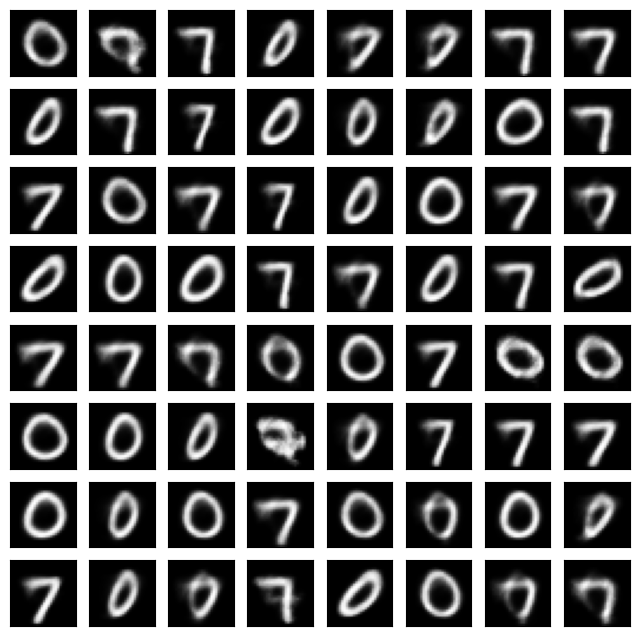

In [12]:
samples = sample_from_vae(model = model_1x, num_samples=64, z_dim=Z_DIM, device=device)
# Plot the generated samples in an 8x8 grid
plt.figure(figsize=(8, 8))  # Adjusted for larger display

for i in range(8):  # Rows
    for j in range(8):  # Columns
        idx = i * 8 + j
        ax = plt.subplot(8, 8, idx + 1)
        plt.imshow(samples[idx], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np  # Importing numpy, as it was used in the previous code but not imported

# Extract embeddings and labels
embeddings, labels = [], []

# Assuming model1 is your trained VAE and train_loader is your DataLoader
for x, y in train_loader:
    x = x.to(device).view(x.shape[0], INPUT_DIM)
    mu, _ = model_1x.encode(x)
    embeddings.append(mu.detach().cpu().numpy())
    labels.append(y.detach().cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

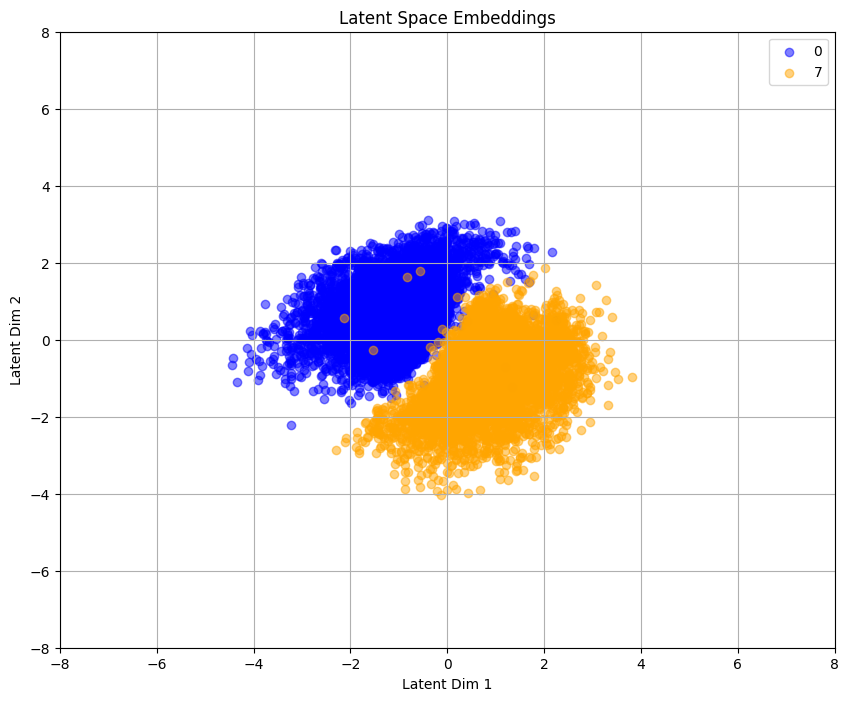

In [14]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[labels==0, 0], embeddings[labels==0, 1], alpha=0.5, label='0', color='blue')
plt.scatter(embeddings[labels==7, 0], embeddings[labels==7, 1], alpha=0.5, label='7', color='orange')

plt.legend()
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Embeddings')
plt.grid(True)


plt.xlim(-8, 8)
plt.ylim(-8, 8)
    
plt.show()

## 3. Investigate points at the centre and the periphery in each digit's latent space of the VAE 

#### 3.1 Method 1

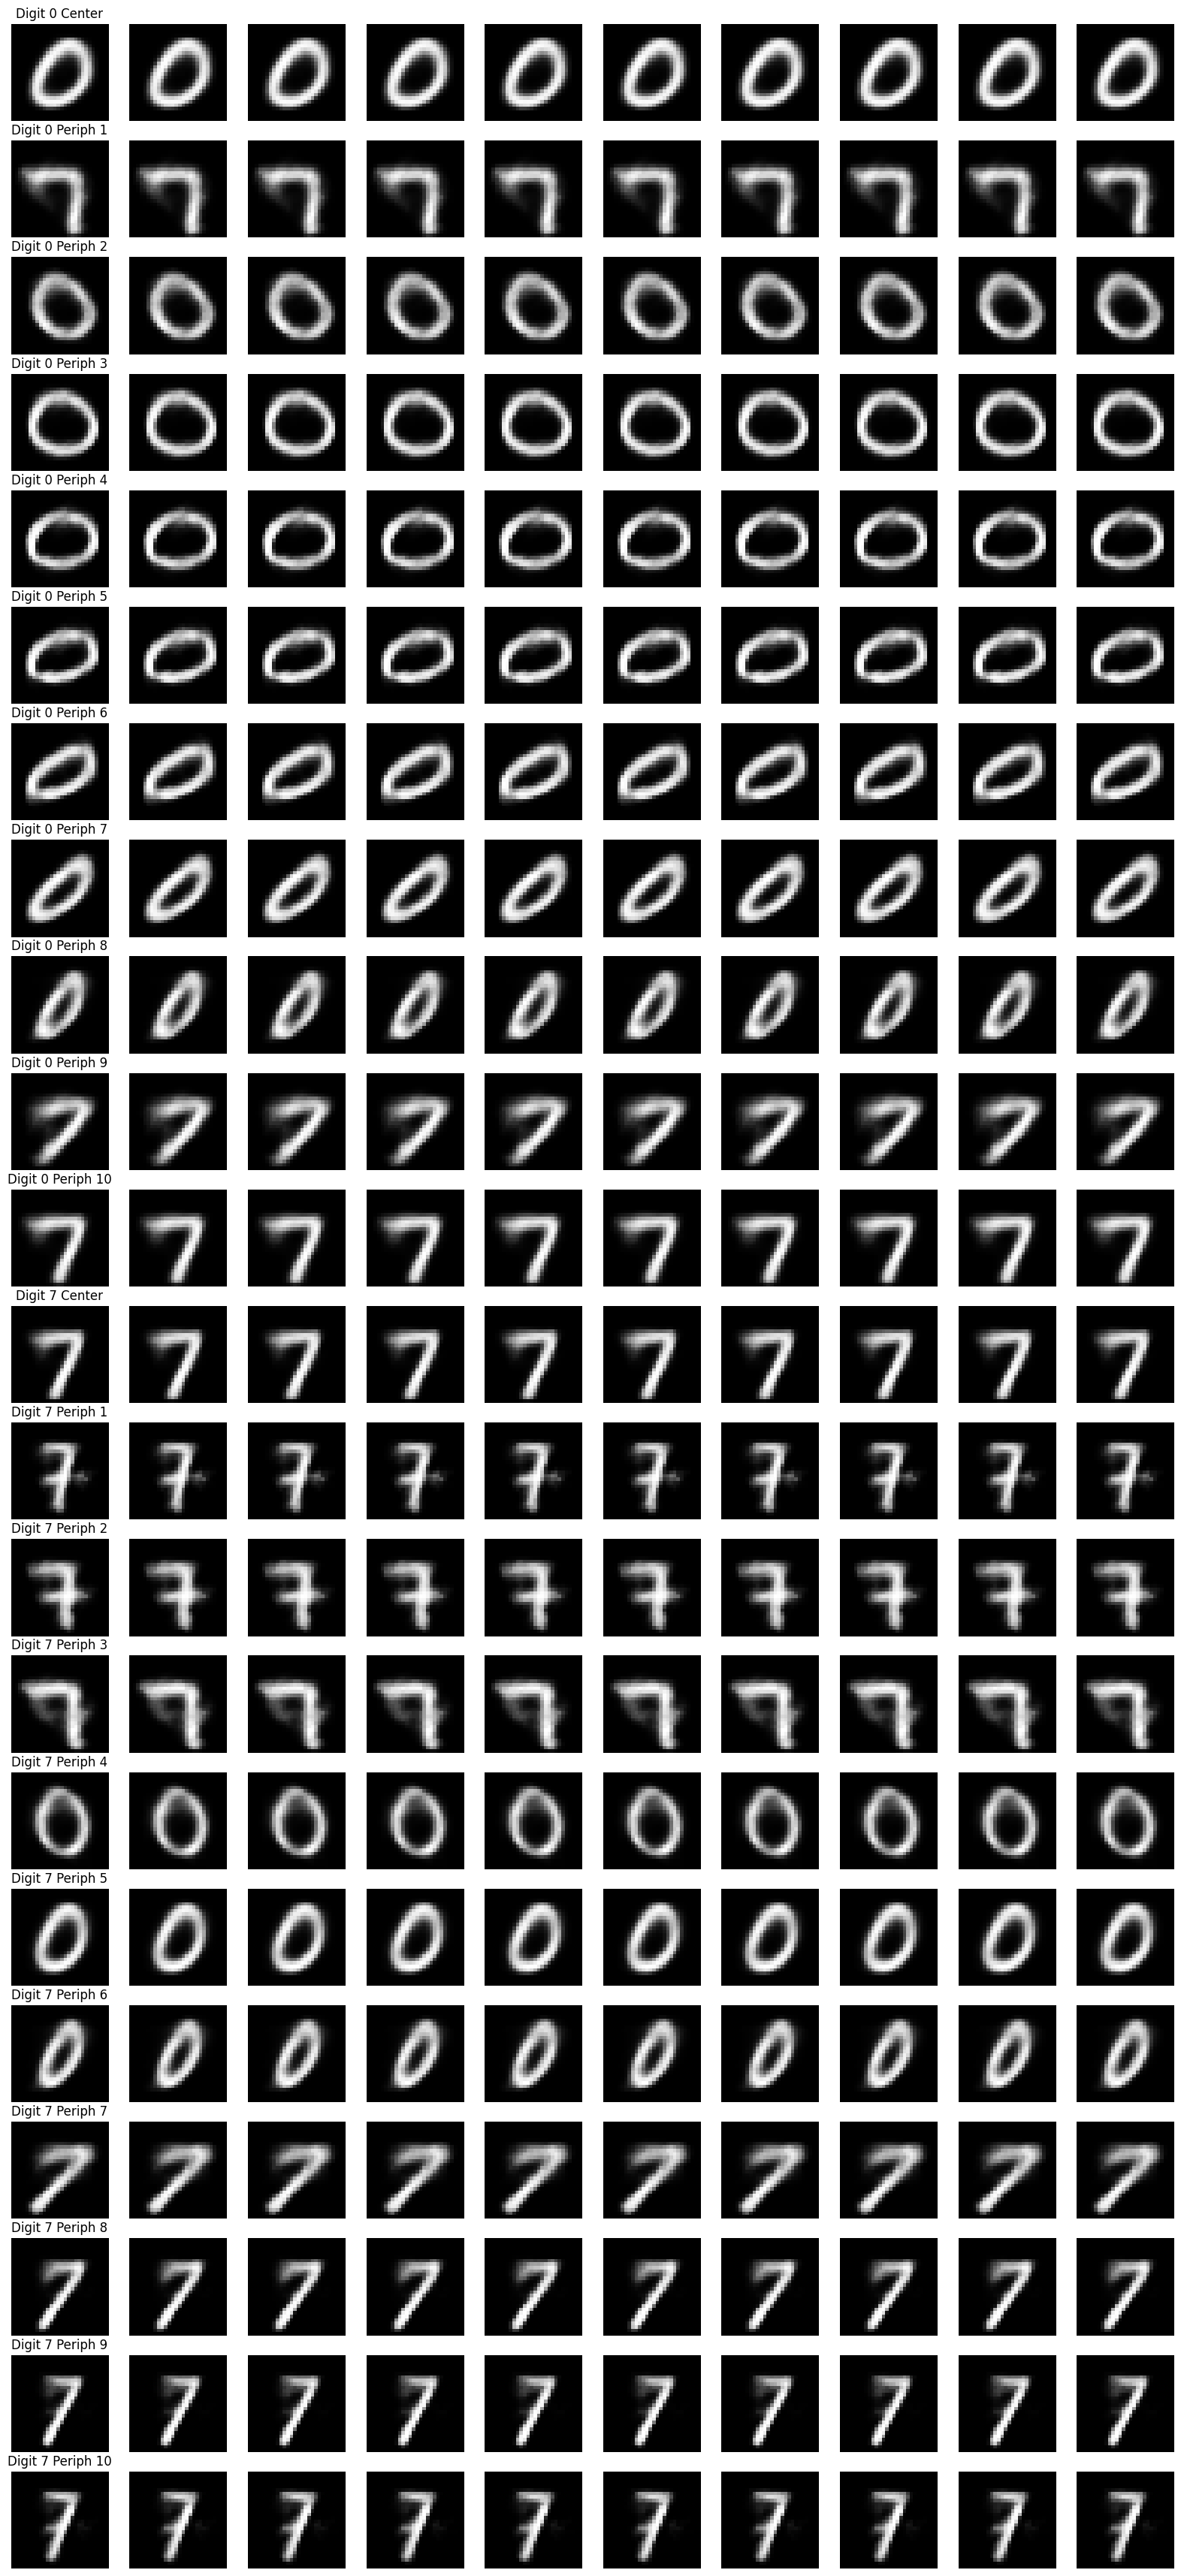

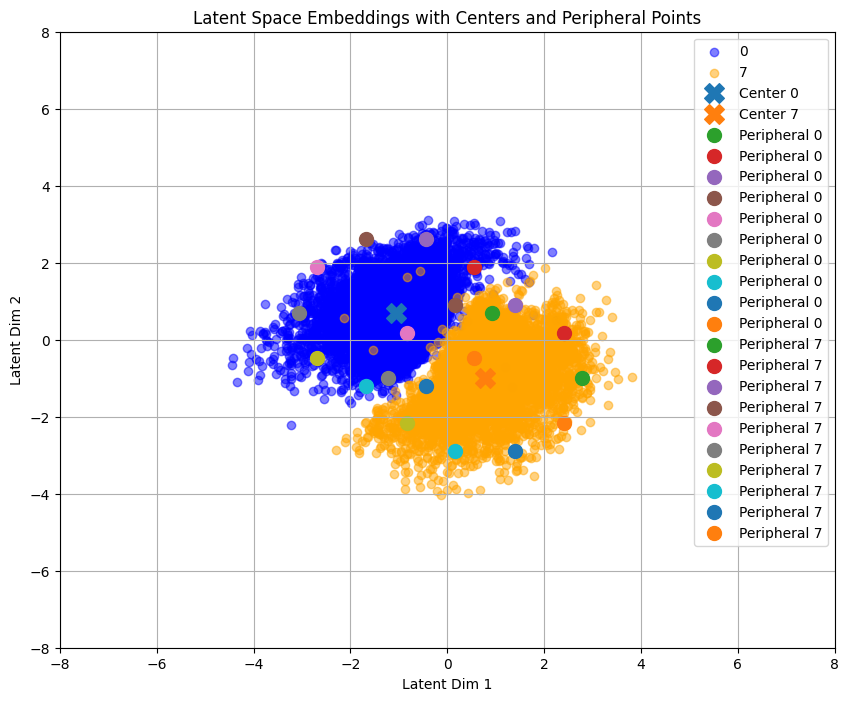

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to find the center of the latent space for each digit
def find_centers(embeddings, labels):
    centers = {}
    for digit in np.unique(labels):
        centers[digit] = embeddings[labels == digit].mean(axis=0)
    return centers

# Function to define peripheral points around each center
def define_peripheral_points(center, num_points=10, radius=2.0):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    peripheral_points = [center + radius * np.array([np.cos(angle), np.sin(angle)]) for angle in angles]
    return peripheral_points

# Function to generate samples from specified points in latent space
def generate_samples_from_points(model, points, num_samples=10, device=torch.device('cpu')):
    model.eval()
    samples = []
    with torch.no_grad():
        for point in points:
            z = torch.tensor(point).to(device).float().unsqueeze(0).repeat(num_samples, 1)
            sample = model.decode(z)
            samples.append(sample.cpu().view(num_samples, 28, 28).numpy())
    return samples

# Find centers of latent space for each digit
centers = find_centers(embeddings, labels)

# Define peripheral points for each center
peripheral_points = {digit: define_peripheral_points(center) for digit, center in centers.items()}

# Generate and plot samples from centers and peripheral points
num_digits = len(centers)
num_points = 10  # Number of peripheral points
total_plots = num_digits * (1 + num_points) * 10  # 1 center + num_points per digit, each with 10 samples
cols = 10  # Number of columns for the plot grid
rows = (total_plots // cols) + (1 if total_plots % cols != 0 else 0)

plt.figure(figsize=(20, rows * 2))

# Generate samples from the center and peripheral points of each latent space
plot_index = 1
for digit, center in centers.items():
    # Generate samples from the center
    center_samples = generate_samples_from_points(model_1x, [center], num_samples=10, device=device)
    for j, sample in enumerate(center_samples[0]):
        if plot_index <= rows * cols:
            ax = plt.subplot(rows, cols, plot_index)
            plt.imshow(sample, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Digit {digit} Center")
            plot_index += 1

    # Generate samples from the peripheral points
    for k, point in enumerate(peripheral_points[digit]):
        peripheral_samples = generate_samples_from_points(model_1x, [point], num_samples=10, device=device)
        for j, sample in enumerate(peripheral_samples[0]):
            if plot_index <= rows * cols:
                ax = plt.subplot(rows, cols, plot_index)
                plt.imshow(sample, cmap='gray')
                ax.axis('off')
                if j == 0:
                    ax.set_title(f"Digit {digit} Periph {k+1}")
                plot_index += 1

plt.show()

# Plot the centers and peripheral points on the latent space plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], alpha=0.5, label='0', color='blue')
plt.scatter(embeddings[labels == 7, 0], embeddings[labels == 7, 1], alpha=0.5, label='7', color='orange')

# Plot centers
for digit, center in centers.items():
    plt.scatter(center[0], center[1], s=200, marker='X', label=f'Center {digit}')

# Plot peripheral points
for digit, points in peripheral_points.items():
    for point in points:
        plt.scatter(point[0], point[1], s=100, marker='o', label=f'Peripheral {digit}')

plt.legend()
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Embeddings with Centers and Peripheral Points')
plt.grid(True)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()


## 3.2 Method 2: Plot the origin to center vs periphery to center

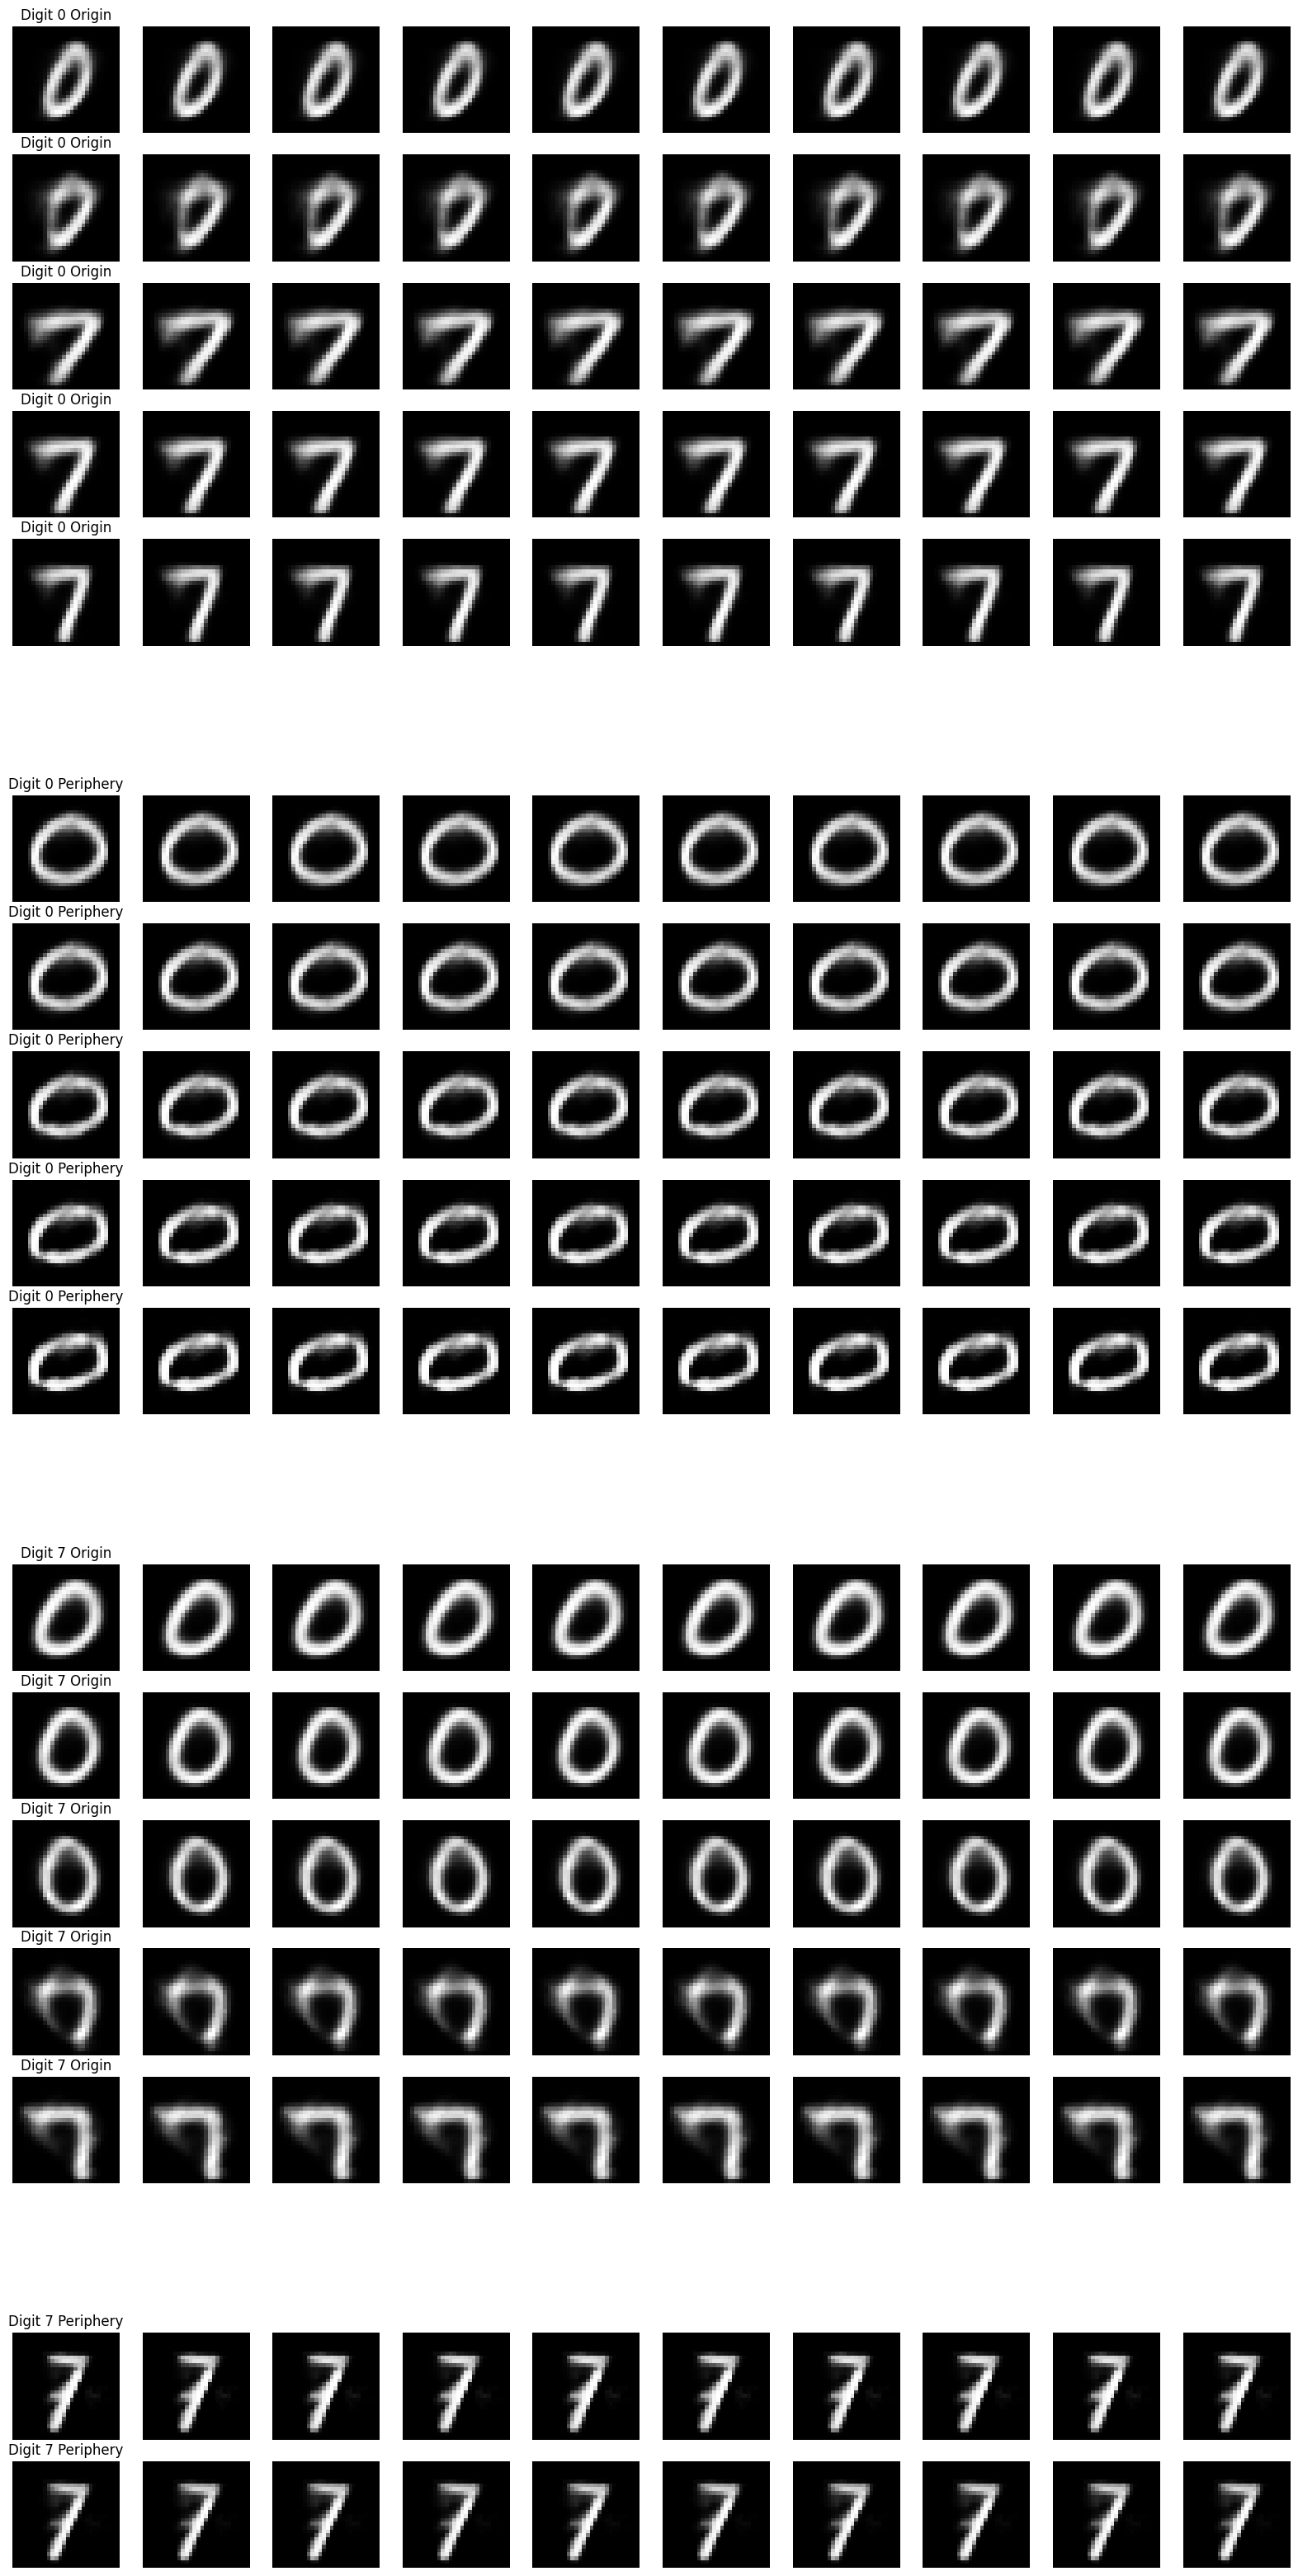

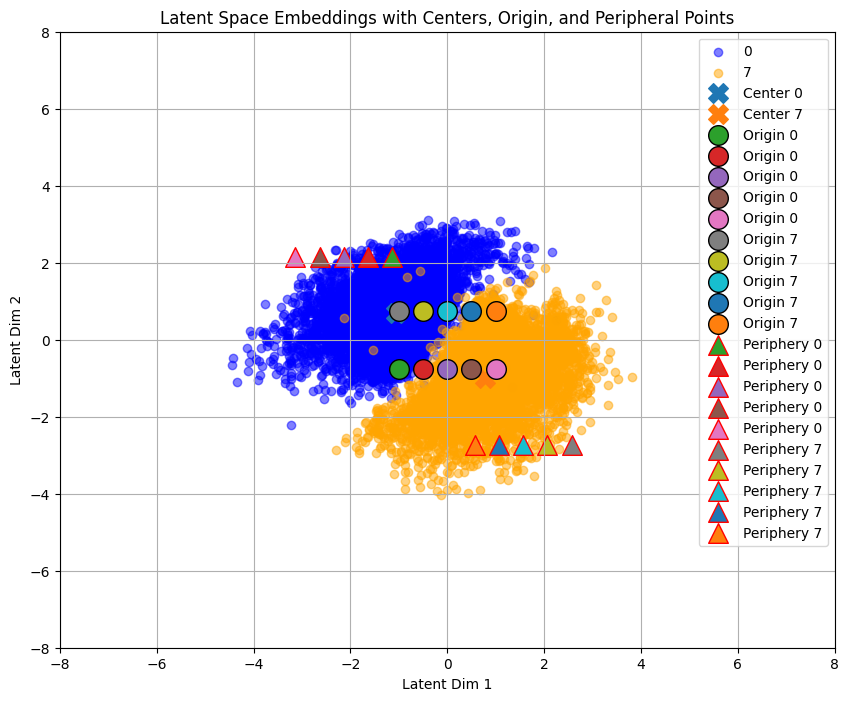

In [17]:
# Function to manually define origin points and equidistant peripheral points
def define_custom_origin_and_peripheral_points():
    origin_points = {
        0: [(-1, -0.75), (-0.5, -0.75), (0.0, -0.75), (0.5, -0.75), (1.0, -0.75)],
        7: [(-1, 0.75), (-0.5, 0.75), (0.0, 0.75), (0.5, 0.75), (1.0, 0.75)]
    }
    
    peripheral_points = {}
    for digit, points in origin_points.items():
        center = centers[digit]
        peripheral_points[digit] = [center + (center - np.array(point)) for point in points]
    
    return origin_points, peripheral_points

# Find centers of latent space for each digit
centers = find_centers(embeddings, labels)

# Define custom origin and equidistant peripheral points for each center
origin_points, peripheral_points = define_custom_origin_and_peripheral_points()

# Generate and plot samples from origin and peripheral points
num_digits = len(centers)
total_plots = num_digits * 100  # 10 samples from 5 origin and 5 periphery points per digit
cols = 10  # Number of columns for the plot grid
rows = (total_plots // cols) + (1 if total_plots % cols != 0 else 0)

plt.figure(figsize=(20, rows * 2))

# Generate samples from the origin and peripheral points of each latent space
plot_index = 1
for digit in centers.keys():
    # Generate samples from the origin points
    for origin_point in origin_points[digit]:
        origin_samples = generate_samples_from_points(model_1x, [origin_point], num_samples=10, device=device)
        for j, sample in enumerate(origin_samples[0]):
            if plot_index <= rows * cols:
                ax = plt.subplot(rows, cols, plot_index)
                plt.imshow(sample, cmap='gray')
                ax.axis('off')
                if j == 0:
                    ax.set_title(f"Digit {digit} Origin")
                plot_index += 1

    # Add space between plots for different digits
    plot_index += cols

    # Generate samples from the peripheral points
    for periph_point in peripheral_points[digit]:
        periph_samples = generate_samples_from_points(model_1x, [periph_point], num_samples=10, device=device)
        for j, sample in enumerate(periph_samples[0]):
            if plot_index <= rows * cols:
                ax = plt.subplot(rows, cols, plot_index)
                plt.imshow(sample, cmap='gray')
                ax.axis('off')
                if j == 0:
                    ax.set_title(f"Digit {digit} Periphery")
                plot_index += 1

    # Add space between plots for different digits
    plot_index += cols

plt.show()

# Plot the centers, origin points, and peripheral points on the latent space plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], alpha=0.5, label='0', color='blue')
plt.scatter(embeddings[labels == 7, 0], embeddings[labels == 7, 1], alpha=0.5, label='7', color='orange')

# Plot centers
for digit, center in centers.items():
    plt.scatter(center[0], center[1], s=200, marker='X', label=f'Center {digit}')

# Plot origin points
for digit, points in origin_points.items():
    for point in points:
        plt.scatter(point[0], point[1], s=200, marker='o', label=f'Origin {digit}', edgecolors='black')

# Plot peripheral points
for digit, points in peripheral_points.items():
    for point in points:
        plt.scatter(point[0], point[1], s=200, marker='^', label=f'Periphery {digit}', edgecolors='red')

plt.legend()
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Embeddings with Centers, Origin, and Peripheral Points')
plt.grid(True)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()